# Popular Data Science Questions
------

### Introduction

Today we are exploring the [Data Science section of Stack Exchange](https://datascience.stackexchange.com/) or refered as DSSE from this point onwards. 

[Stack Exchange](https://stackexchange.com/) is a website that allows people to ask questions about a number of different topics. The questions and answers are ranked by votes (similar to Reddit), the amount of answers a particular question have and also the views for that question itself.

As mentioned above, DSSE is the a branch of Stack Exchange which answers questions about data science. The type of questions in this site can be quite technical i.e. how to do certain things, but can be quite subjective too.

### SEDE (Stack Exchange Data Explorer)

Stack Exchange provides a public-facing database for each site that enables efficient data analysis without having to scrape the sites.

Here is the link to the [Data Science Stack Exchange Data Explorer](https://data.stackexchange.com/datascience/query/new) that accepts Transact-SQL queries. Transact-SQL (also called Microsoft's SQL) is a SQL dialect that is a bit different from SQLite. One of the difference is that instead of using LIMIT, we will use TOP.

View database schema in full resolution [here](https://i.stack.imgur.com/AyIkW.png)

![Database Schema](https://i.stack.imgur.com/AyIkW.png)

Because we are trying to analyze questions, the most logical place to start is the Posts table. Other tables that might be useful includes :
- Posttags 
- Posttypes
- Tags
- Tagsynonyms

Query to view top 10 most frequently used tags:

<pre><code>
SELECT TOP 10 *    
  FROM Tags    
 ORDER BY Count DESC;
</code></pre>

|Id|TagName|Count|ExcerptPostId|WikiPostId|
|---|---|---|---|---|
|2|machine-learning|8546|4909|4908|
|46|python|4960|5523|5522|
|81|neural-network|3553|8885|8884|
|194|deep-learning|3544|8956|8955|
|77|classification|2425|4911|4910|
|324|keras|2226|9251|9250|     
|128|scikit-learn|1745|5896|5895|      
|321|tensorflow|1665|9183|9182|    
|47|nlp|1613|147|146|      
|72|time-series|1289|8904|8903|

Tags is a useful table since it shows the usage frequency of a particular tag.

Query to view post types:

<pre><code>
SELECT *
  FROM PostTypes;
</code></pre>

|Id|Name|
|---|---|
|1|Question|
|2|Answer|
|3|Wiki|
|4|TagWikiExcerpt|
|5|TagWiki|
|6|ModeratorNomination|
|7|WikiPlaceholder|
|8|PrivilegeWiki|

Since we are only interested in questions asked, we will only select number 1.

Query to view the most recent post creation date:

<pre><code>
SELECT MAX(CreationDate)
  FROM Posts;
</code></pre>

|Results|
|---|
|2021-02-06 22:43:58|

Query to view the oldest post creation date:

<pre><code>
SELECT MIN(CreationDate)
  FROM Posts;
</code></pre>

|Results|
|---|
|2014-05-13 23:58:30 | 

Since SEDE contains data from many years past (the oldest being from 2014-05-13 23:58:30), for this particular exercise we are limiting it from 2019 only

Query to view the post

<pre><code>
SELECT Id,
       PostTypeId,
       CreationDate,
       Score,
       ViewCount,
       Tags,
       AnswerCount,
       FavoriteCount
FROM Posts
WHERE YEAR(CreationDate)='2019' AND PostTypeId=1;
</code></pre>

|Id|PostTypeId|CreationDate|Score|ViewCount|Tags|AnswerCount|FavoriteCount|
|---|---|---|---|---|---|---|---|
|55645|1|2019-07-14 14:05:51|0|124|<python><logistic-regression>|0|1|          
|55646|1|2019-07-14 14:06:13|0|27|<machine-learning><multiclass-classification><loss-function><metric>|0|null|          
|55647|1|2019-07-14 14:37:51|6|907|<machine-learning><neural-network><deep-learning><machine-translation>|1|1|                         

The three rows above are a sample of the rows that we are selecting. The data will be downloaded from SEDE into a file called **2019_questions.csv**

### Data Exploration

#### 1. Prerequisite

In [1]:
#Importing the modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

sns.set_style('white')

In [2]:
#Importing the dataset and showing the first 3 data
ds=pd.read_csv('2019_questions.csv',parse_dates=['CreationDate'])
ds.head(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN


In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


In [4]:
ds['FavoriteCount'].value_counts(dropna=False)

NaN      7432
 1.0      953
 2.0      205
 0.0      175
 3.0       43
 4.0       12
 5.0        8
 6.0        4
 7.0        4
 11.0       1
 8.0        1
 16.0       1
Name: FavoriteCount, dtype: int64

After looking at the first three data and column info, we notice that missing values do exist but only in the column FavoriteCount. A viable strategy is to fill it with 0 instead of letting it be. We can also convert the value of that column into integers.

Every column except the aforementioned seems to be in the right data type.

The column 'Tags' is a tricky one. An option is to split it into individual columns, but it seems unnecessary, so instead we are replacing the first '<' and the last '>' with nothing and then using '><' to split it into lists.


#### 2. Data Cleaning

In [5]:
#Filling FavoriteCount's NaN value with 0
ds['FavoriteCount'].fillna(0,inplace=True)
ds['FavoriteCount']=ds['FavoriteCount'].astype(int)
ds['FavoriteCount'].value_counts()

0     7607
1      953
2      205
3       43
4       12
5        8
7        4
6        4
11       1
16       1
8        1
Name: FavoriteCount, dtype: int64

In [6]:
#Cleaning the Tags column
ds['Tags']=ds['Tags'].str.replace(r'^<|>$','').str.split('><')
ds.head(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,"[machine-learning, data-mining]",0,0
1,44420,2019-01-23 09:34:01,0,25,"[machine-learning, regression, linear-regressi...",0,0
2,44423,2019-01-23 09:58:41,2,1651,"[python, time-series, forecast, forecasting]",0,0


### Data Analysis

#### 1. How many times a tag has been used?

In [7]:
#Counting each element of the list and appending it into a dict
count_use={}
for i in ds['Tags']:
    for j in i:
        if j in count_use: count_use[j]+=1
        else: count_use[j]=1

#Converting the dict into a dataframe and sorting it by count
count_use = pd.DataFrame.from_dict(count_use, orient="index")
count_use.rename(columns={0: "count"}, inplace=True)
count_use.sort_values(by='count',ascending=True,inplace=True)
top_25_use=count_use.tail(25)
top_25_use

,count
reinforcement-learning,203
feature-selection,209
image-classification,211
data,213
data-mining,217
machine-learning-model,224
statistics,234
clustering,257
predictive-modeling,265
r,268


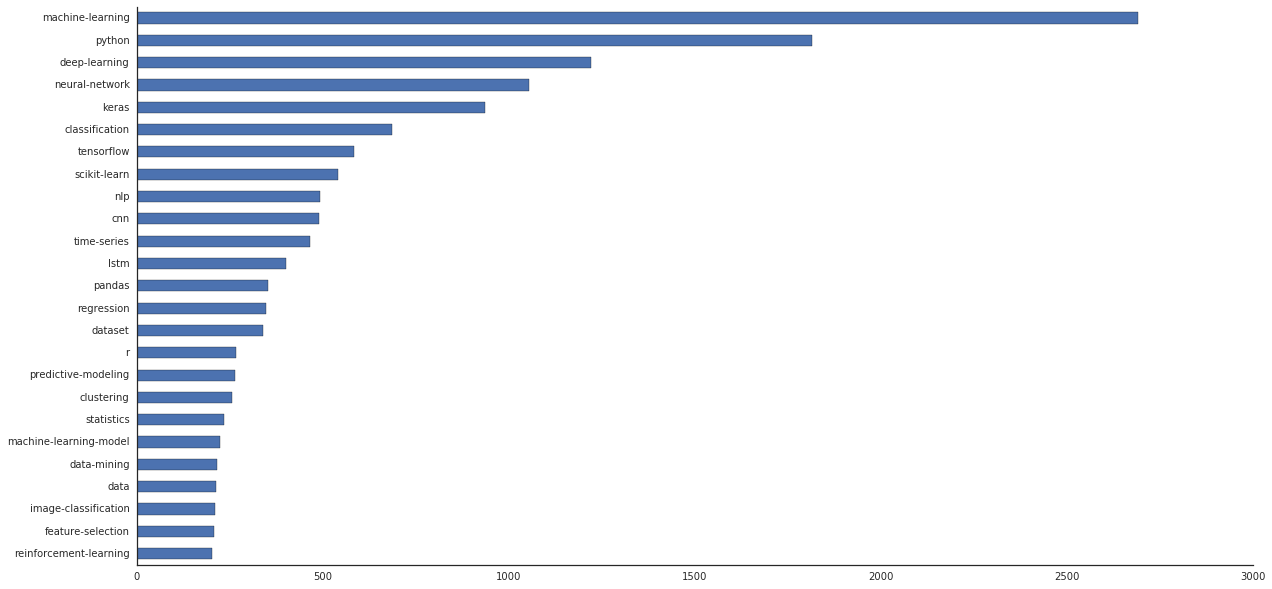

In [8]:
#Visualizing top_25_use
fig, ax = plt.subplots()
top_25_use.plot(kind='barh',legend=False,figsize=(20,10),ax=ax)

#Turning off top and right spines and ticks
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

As we can see, Machine Learning, Python, and Deep Learning are three most used tags in DSSE.

#### 2. How many times a tag has been viewed

In [9]:
#Counting each element of the list and appending it into a dict

tag_view_count = dict()

for index, row in ds.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']

#Converting the dict into a dataframe and sorting it by count
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index")
tag_view_count.rename(columns={0: "count"}, inplace=True)
tag_view_count.sort_values(by='count',ascending=True,inplace=True)
top_25_count=tag_view_count.tail(25)
top_25_count

,count
xgboost,31533
seaborn,32244
computer-vision,32502
image-classification,33238
r,33684
clustering,33928
csv,38654
pytorch,40240
dataset,43151
regression,49451


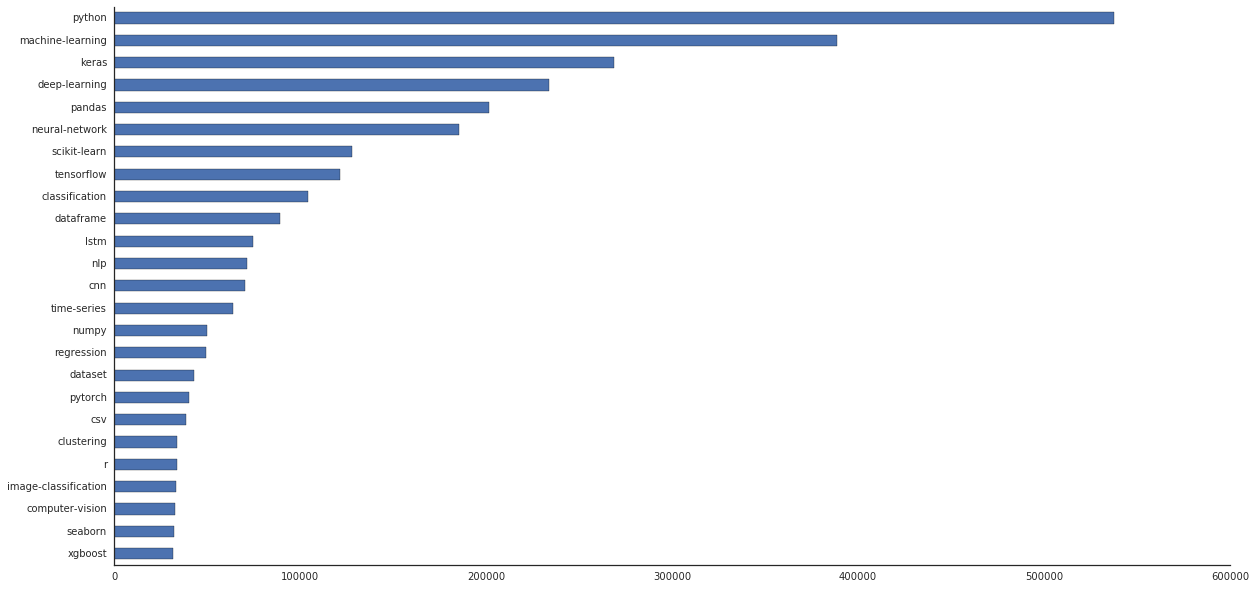

In [10]:
#Visualizing top_25_use
fig, ax = plt.subplots()
top_25_count.plot(kind='barh',legend=False,figsize=(20,10),ax=ax)

#Turning off top and right spines and ticks
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

As we can see, Python, Machine Learning, and Keras are the three most viewed tags in DSSE.

#### 3. Finding the relation between tags


One way of trying to gauge how pairs of tags are related to each other, is to count how many times each pair appears together. Let's do this.

We'll begin by creating a list of all tags.

In [11]:
all_tags=list(count_use.index)

Next we are creating a relationship dataframe

In [ ]:
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.fillna(0,inplace=True)
associations.iloc[0:4,0:4]

,rdkit,hurdle-model,rmse,nl2sql
rdkit,0,0,0,0
hurdle-model,0,0,0,0
rmse,0,0,0,0
nl2sql,0,0,0,0


If a tag appears together, we are adding one to the value

In [ ]:
for i in ds['Tags']:
    associations.loc[i, i] += 1

Now we are displaying the relations in form of a table.

In [ ]:

relations_most_used = associations.loc[top_25_count.index, top_25_count.index]

def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = "color: blue"
    
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)


The cells highlighted in yellow tell us that time-series was used together with r 22 times. The values in blue tell us how many times each of the tags was used. We saw earlier that machine-learning was used 2693 times and we confirm it in this dataframe.

It's hard for a human to understand what is going on in this dataframe. Let's create a heatmap. But before we do it, let's get rid of the values in blue, otherwise the colors will be too skewed.

In [ ]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Reds", annot=False)

As you can see, the darker the color, the greater the frequency of a tag showing up together. Whites are reserved for columns and rows anotating the same row.

The most intense pairing is machine-learning and python while the least is xgboost and seaborn.

#### 4. Is deep learning just a fad?

Let's check the popularity of the `deep learning` category over the years.

DSSE Data Explorer query to view all questions and tags:

<pre><code>
SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;
</code></pre>

The results are exported to `all_questions.csv` and loaded into a dataframe below. We will analyze the tags in a similar fashion that we used already, but this time we will focus on the deep learning subject and consider all questions since the site's launch as opposed to just 2020.

In [ ]:
#Importing the new CSV
all_q = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])
all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")

The tags that indicates deep-learning includes ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]. Thus we can actually check if that either one or none of tags in that list is included.

In [ ]:
def dep(x):
    for tag in x:
        if tag in ["lstm", "cnn", "scikit-learn", 
        "tensorflow", "keras", "neural-network", "deep-learning"]:
            return 1
        else:return 0

In [ ]:
#Using the function above to check if the question is about deep learning
all_q['DeepTrue']=all_q['Tags'].apply(dep)
all_q.head(3)

Now the main question is how can we categorize it. It is wise to categorize it based on CreationDate particularly quarters.

In [ ]:
all_q=all_q[all_q['CreationDate'].dt.year<2020]

In [ ]:
def cd_quarter(x):
    year=str(x.year)[-2:]
    quarter=str((x.month//3)+1)
    return '{y}Q{q}'.format(y=year,q=quarter)

In [ ]:
all_q['quarter']=all_q['CreationDate'].apply(cd_quarter)
all_q.head(3)

In [ ]:
quarterly = all_q.groupby('quarter').agg({"DeepTrue": ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]\
                                /quarterly["TotalQuestions"]

# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)
quarterly.sample(5)

In [ ]:
ax1 = quarterly.plot(x="quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

There is a positive trend in people's question about deep learning, thus it is wise to explore posibilities to create services in this area.

### Conclusion

- Machine Learning, Python, and Deep Learning are three most used tags in DSSE.
- Python, Machine Learning, and Keras are the three most viewed tags in DSSE.
- The most intense pairing is machine-learning and python while the least is xgboost and seaborn.
- There is a positive trend in people's question about deep learning, thus it is wise to explore posibilities to create services in this area.